In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import datetime
import time

%matplotlib inline

In [3]:
data = pd.read_csv("../dataset/T1.csv")
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [5]:
data.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776282,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [6]:
data.isnull().sum()


Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [7]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'],format="%d %m %Y %H:%M")


In [8]:
data['Year'] = data['Date/Time'].dt.year
data['Month'] = data['Date/Time'].dt.month
data['Day'] = data['Date/Time'].dt.day
data['Time_Hours'] = data['Date/Time'].dt.hour
data['Time_Minutes'] = data['Date/Time'].dt.minute

In [9]:
data.columns

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'Year', 'Month',
       'Day', 'Time_Hours', 'Time_Minutes'],
      dtype='object')

In [10]:
cols = [ 'Year', 'Month', "Day", "Time_Hours", "Time_Minutes" ]
data = data.drop(cols, axis=1)
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [11]:
df = data.copy()

# Building LSTM 

In [12]:



from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [13]:
# converting the Data/Time as the index for proper shape of the input.
df = df.set_index('Date/Time')

In [14]:
# Hardcode all variables
batch_size_exp = 1
epoch_exp = 15
neurons_exp = 10
predict_values_exp = 1000
lag_exp=24

In [15]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [16]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [17]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [18]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [19]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [20]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = tf.keras.models.Sequential()
    
    # Use LSTM layer with CuDNN backend if available
    if tf.test.is_gpu_available(cuda_only=True):
        model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    else:
        model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, implementation=2))
    
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    
    # Print model summary after training
    print(model.summary())
    
    return model

In [21]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [22]:
df.columns

Index(['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [23]:
'''Drop all the features as we will not be having any in production'''
del df['LV ActivePower (kW)']
del df['Theoretical_Power_Curve (KWh)']
del df['Wind Speed (m/s)']
df.head()

,Wind Direction (°)
Date/Time,
2018-01-01 00:00:00,259.994904
2018-01-01 00:10:00,268.641113
2018-01-01 00:20:00,272.564789
2018-01-01 00:30:00,271.258087
2018-01-01 00:40:00,265.674286


In [24]:
for i in range(0,10):
  df = df[:-1]
df.tail()

,Wind Direction (°)
Date/Time,
2018-12-31 21:30:00,79.699562
2018-12-31 21:40:00,80.132507
2018-12-31 21:50:00,80.081612
2018-12-31 22:00:00,80.452248
2018-12-31 22:10:00,80.960693


In [25]:
# transform data to be stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [26]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [27]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [28]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [29]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


49519/49519 [==============================] - 173s 3ms/step - loss: 0.0098
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10)                   1400      
                                                                 
 dense (Dense)               (1, 1)                    11        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [30]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
predictions_plot = list()
expectations_plot = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    predictions_plot.append(yhat)
    expectations_plot.append(expected)
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 1s 901ms/step
Hour=1, Predicted=222.693208, Expected=218.798798
1/1 [==============================] - 0s 40ms/step
Hour=2, Predicted=219.625450, Expected=217.778305
1/1 [==============================] - 0s 32ms/step
Hour=3, Predicted=217.608092, Expected=219.025497
1/1 [==============================] - 0s 40ms/step
Hour=4, Predicted=218.963519, Expected=259.750488
1/1 [==============================] - 0s 32ms/step
Hour=5, Predicted=259.615448, Expected=311.271210
1/1 [==============================] - 0s 40ms/step
Hour=6, Predicted=310.921179, Expected=342.778809
1/1 [==============================] - 0s 40ms/step
Hour=7, Predicted=342.760486, Expected=350.314697
1/1 [==============================] - 0s 40ms/step
Hour=8, Predicted=350.459035, Expected=358.158691
1/1 [==============================] - 0s 24ms/step
Hour=9, Predicted=357.872760, Expected=339.134888
1/1 [==============================] - 0s 40ms/step
Hour=10, Predicted=338.833604

1/1 [==============================] - 0s 56ms/step
Hour=82, Predicted=27.251518, Expected=30.173679
1/1 [==============================] - 0s 56ms/step
Hour=83, Predicted=30.388693, Expected=28.026951
1/1 [==============================] - 0s 48ms/step
Hour=84, Predicted=28.241981, Expected=29.069679
1/1 [==============================] - 0s 56ms/step
Hour=85, Predicted=29.286193, Expected=28.324301
1/1 [==============================] - 0s 32ms/step
Hour=86, Predicted=28.539939, Expected=28.582920
1/1 [==============================] - 0s 24ms/step
Hour=87, Predicted=28.798078, Expected=27.415751
1/1 [==============================] - 0s 25ms/step
Hour=88, Predicted=27.632076, Expected=29.268961
1/1 [==============================] - 0s 24ms/step
Hour=89, Predicted=29.485013, Expected=31.545719
1/1 [==============================] - 0s 48ms/step
Hour=90, Predicted=31.761091, Expected=33.882069
1/1 [==============================] - 0s 49ms/step
Hour=91, Predicted=34.098190, Expected=

Hour=162, Predicted=21.884825, Expected=22.317539
1/1 [==============================] - 0s 32ms/step
Hour=163, Predicted=22.533169, Expected=22.765690
1/1 [==============================] - 0s 32ms/step
Hour=164, Predicted=22.981309, Expected=21.016661
1/1 [==============================] - 0s 32ms/step
Hour=165, Predicted=21.232285, Expected=22.097601
1/1 [==============================] - 0s 32ms/step
Hour=166, Predicted=22.313224, Expected=21.215990
1/1 [==============================] - 0s 33ms/step
Hour=167, Predicted=21.431615, Expected=19.397739
1/1 [==============================] - 0s 32ms/step
Hour=168, Predicted=19.613361, Expected=14.130290
1/1 [==============================] - 0s 32ms/step
Hour=169, Predicted=14.345912, Expected=13.194050
1/1 [==============================] - 0s 32ms/step
Hour=170, Predicted=13.409676, Expected=14.396870
1/1 [==============================] - 0s 40ms/step
Hour=171, Predicted=14.612489, Expected=14.107920
1/1 [===========================

1/1 [==============================] - 0s 24ms/step
Hour=243, Predicted=33.190461, Expected=44.181370
1/1 [==============================] - 0s 24ms/step
Hour=244, Predicted=44.396996, Expected=40.483959
1/1 [==============================] - 0s 24ms/step
Hour=245, Predicted=40.699577, Expected=39.234230
1/1 [==============================] - 0s 32ms/step
Hour=246, Predicted=39.449852, Expected=50.722759
1/1 [==============================] - 0s 24ms/step
Hour=247, Predicted=50.938382, Expected=49.377411
1/1 [==============================] - 0s 24ms/step
Hour=248, Predicted=49.593037, Expected=55.363239
1/1 [==============================] - 0s 24ms/step
Hour=249, Predicted=55.578865, Expected=42.802319
1/1 [==============================] - 0s 24ms/step
Hour=250, Predicted=43.017943, Expected=46.921879
1/1 [==============================] - 0s 24ms/step
Hour=251, Predicted=47.137497, Expected=48.029289
1/1 [==============================] - 0s 48ms/step
Hour=252, Predicted=48.244915,

1/1 [==============================] - 0s 32ms/step
Hour=323, Predicted=40.107436, Expected=33.959549
1/1 [==============================] - 0s 32ms/step
Hour=324, Predicted=34.175175, Expected=34.341179
1/1 [==============================] - 0s 32ms/step
Hour=325, Predicted=34.556803, Expected=31.732071
1/1 [==============================] - 0s 32ms/step
Hour=326, Predicted=31.947690, Expected=12.762190
1/1 [==============================] - 0s 32ms/step
Hour=327, Predicted=12.977812, Expected=8.975563
1/1 [==============================] - 0s 52ms/step
Hour=328, Predicted=9.191185, Expected=358.090088
1/1 [==============================] - 0s 32ms/step
Hour=329, Predicted=358.305715, Expected=343.325500
1/1 [==============================] - 0s 32ms/step
Hour=330, Predicted=343.541125, Expected=21.333170
1/1 [==============================] - 0s 32ms/step
Hour=331, Predicted=21.548794, Expected=19.139200
1/1 [==============================] - 0s 32ms/step
Hour=332, Predicted=19.35482

1/1 [==============================] - 0s 24ms/step
Hour=403, Predicted=2.306923, Expected=5.286382
1/1 [==============================] - 0s 56ms/step
Hour=404, Predicted=5.502004, Expected=359.485596
1/1 [==============================] - 0s 51ms/step
Hour=405, Predicted=359.701218, Expected=359.611511
1/1 [==============================] - 0s 48ms/step
Hour=406, Predicted=359.827141, Expected=354.871887
1/1 [==============================] - 0s 48ms/step
Hour=407, Predicted=355.087512, Expected=351.967895
1/1 [==============================] - 0s 48ms/step
Hour=408, Predicted=352.183512, Expected=6.698527
1/1 [==============================] - 0s 40ms/step
Hour=409, Predicted=6.914150, Expected=356.661713
1/1 [==============================] - 0s 40ms/step
Hour=410, Predicted=356.877337, Expected=5.666049
1/1 [==============================] - 0s 57ms/step
Hour=411, Predicted=5.881672, Expected=2.101259
1/1 [==============================] - 0s 48ms/step
Hour=412, Predicted=2.316882

1/1 [==============================] - 0s 32ms/step
Hour=483, Predicted=118.373520, Expected=143.424896
1/1 [==============================] - 0s 32ms/step
Hour=484, Predicted=143.640519, Expected=146.645905
1/1 [==============================] - 0s 42ms/step
Hour=485, Predicted=146.861532, Expected=159.386505
1/1 [==============================] - 0s 32ms/step
Hour=486, Predicted=159.602131, Expected=159.932297
1/1 [==============================] - 0s 24ms/step
Hour=487, Predicted=160.147915, Expected=152.750595
1/1 [==============================] - 0s 32ms/step
Hour=488, Predicted=152.966218, Expected=158.631195
1/1 [==============================] - 0s 32ms/step
Hour=489, Predicted=158.846817, Expected=134.950806
1/1 [==============================] - 0s 32ms/step
Hour=490, Predicted=135.166425, Expected=116.633797
1/1 [==============================] - 0s 32ms/step
Hour=491, Predicted=116.849424, Expected=86.577087
1/1 [==============================] - 0s 32ms/step
Hour=492, Pre

1/1 [==============================] - 0s 32ms/step
Hour=562, Predicted=222.723925, Expected=229.696793
1/1 [==============================] - 0s 24ms/step
Hour=563, Predicted=229.912420, Expected=230.334503
1/1 [==============================] - 0s 24ms/step
Hour=564, Predicted=230.550121, Expected=227.530106
1/1 [==============================] - 0s 32ms/step
Hour=565, Predicted=227.745729, Expected=230.422195
1/1 [==============================] - 0s 32ms/step
Hour=566, Predicted=230.637817, Expected=233.796005
1/1 [==============================] - 0s 56ms/step
Hour=567, Predicted=234.011628, Expected=241.136993
1/1 [==============================] - 0s 33ms/step
Hour=568, Predicted=241.352621, Expected=239.706207
1/1 [==============================] - 0s 40ms/step
Hour=569, Predicted=239.921832, Expected=235.857193
1/1 [==============================] - 0s 24ms/step
Hour=570, Predicted=236.072818, Expected=230.552505
1/1 [==============================] - 0s 48ms/step
Hour=571, Pr

1/1 [==============================] - 0s 40ms/step
Hour=641, Predicted=255.906128, Expected=254.699005
1/1 [==============================] - 0s 40ms/step
Hour=642, Predicted=254.914631, Expected=260.461609
1/1 [==============================] - 0s 32ms/step
Hour=643, Predicted=260.677228, Expected=259.118805
1/1 [==============================] - 0s 40ms/step
Hour=644, Predicted=259.334427, Expected=263.677704
1/1 [==============================] - 0s 32ms/step
Hour=645, Predicted=263.893327, Expected=266.188507
1/1 [==============================] - 0s 32ms/step
Hour=646, Predicted=266.404134, Expected=261.711700
1/1 [==============================] - 0s 30ms/step
Hour=647, Predicted=261.927325, Expected=257.805786
1/1 [==============================] - 0s 32ms/step
Hour=648, Predicted=258.021412, Expected=263.521515
1/1 [==============================] - 0s 32ms/step
Hour=649, Predicted=263.737137, Expected=265.727997
1/1 [==============================] - 0s 32ms/step
Hour=650, Pr

1/1 [==============================] - 0s 34ms/step
Hour=720, Predicted=33.342743, Expected=31.999310
1/1 [==============================] - 0s 32ms/step
Hour=721, Predicted=32.214934, Expected=30.943451
1/1 [==============================] - 0s 24ms/step
Hour=722, Predicted=31.159077, Expected=30.602200
1/1 [==============================] - 0s 25ms/step
Hour=723, Predicted=30.817823, Expected=30.964350
1/1 [==============================] - 0s 24ms/step
Hour=724, Predicted=31.179969, Expected=31.092180
1/1 [==============================] - 0s 47ms/step
Hour=725, Predicted=31.307803, Expected=26.995390
1/1 [==============================] - 0s 32ms/step
Hour=726, Predicted=27.211013, Expected=26.269791
1/1 [==============================] - 0s 24ms/step
Hour=727, Predicted=26.485417, Expected=31.339319
1/1 [==============================] - 0s 21ms/step
Hour=728, Predicted=31.554945, Expected=29.467640
1/1 [==============================] - 0s 32ms/step
Hour=729, Predicted=29.683266,

1/1 [==============================] - 0s 48ms/step
Hour=800, Predicted=18.398011, Expected=254.585007
1/1 [==============================] - 0s 25ms/step
Hour=801, Predicted=254.800630, Expected=157.761505
1/1 [==============================] - 0s 24ms/step
Hour=802, Predicted=157.977132, Expected=65.090683
1/1 [==============================] - 0s 24ms/step
Hour=803, Predicted=65.306308, Expected=48.928120
1/1 [==============================] - 0s 24ms/step
Hour=804, Predicted=49.143746, Expected=9.620764
1/1 [==============================] - 0s 27ms/step
Hour=805, Predicted=9.836380, Expected=28.925930
1/1 [==============================] - 0s 24ms/step
Hour=806, Predicted=29.141552, Expected=34.221142
1/1 [==============================] - 0s 16ms/step
Hour=807, Predicted=34.436766, Expected=56.046059
1/1 [==============================] - 0s 24ms/step
Hour=808, Predicted=56.261683, Expected=62.828789
1/1 [==============================] - 0s 27ms/step
Hour=809, Predicted=63.04440

1/1 [==============================] - 0s 32ms/step
Hour=880, Predicted=233.507223, Expected=240.443405
1/1 [==============================] - 0s 30ms/step
Hour=881, Predicted=240.659030, Expected=252.397797
1/1 [==============================] - 0s 32ms/step
Hour=882, Predicted=252.613413, Expected=256.752289
1/1 [==============================] - 0s 40ms/step
Hour=883, Predicted=256.967912, Expected=262.945099
1/1 [==============================] - 0s 24ms/step
Hour=884, Predicted=263.160719, Expected=259.824005
1/1 [==============================] - 0s 40ms/step
Hour=885, Predicted=260.039627, Expected=263.031586
1/1 [==============================] - 0s 32ms/step
Hour=886, Predicted=263.247216, Expected=259.610413
1/1 [==============================] - 0s 25ms/step
Hour=887, Predicted=259.826037, Expected=258.610687
1/1 [==============================] - 0s 24ms/step
Hour=888, Predicted=258.826311, Expected=251.707398
1/1 [==============================] - 0s 24ms/step
Hour=889, Pr

1/1 [==============================] - 0s 48ms/step
Hour=960, Predicted=70.538012, Expected=72.430473
1/1 [==============================] - 0s 48ms/step
Hour=961, Predicted=72.646099, Expected=74.770714
1/1 [==============================] - 0s 48ms/step
Hour=962, Predicted=74.986334, Expected=74.835281
1/1 [==============================] - 0s 32ms/step
Hour=963, Predicted=75.050903, Expected=76.580833
1/1 [==============================] - 0s 26ms/step
Hour=964, Predicted=76.796455, Expected=74.678101
1/1 [==============================] - 0s 53ms/step
Hour=965, Predicted=74.893726, Expected=75.286987
1/1 [==============================] - 0s 49ms/step
Hour=966, Predicted=75.502615, Expected=76.233170
1/1 [==============================] - 0s 49ms/step
Hour=967, Predicted=76.448793, Expected=76.356567
1/1 [==============================] - 0s 68ms/step
Hour=968, Predicted=76.572187, Expected=76.052834
1/1 [==============================] - 0s 48ms/step
Hour=969, Predicted=76.268454,

In [31]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10)                   1400      
                                                                 
 dense (Dense)               (1, 1)                    11        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Calculating Mean Absolute Error

In [32]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))))

Mean Absolute Percent Error:  1.8402017612902215


# Final Prediction Plot

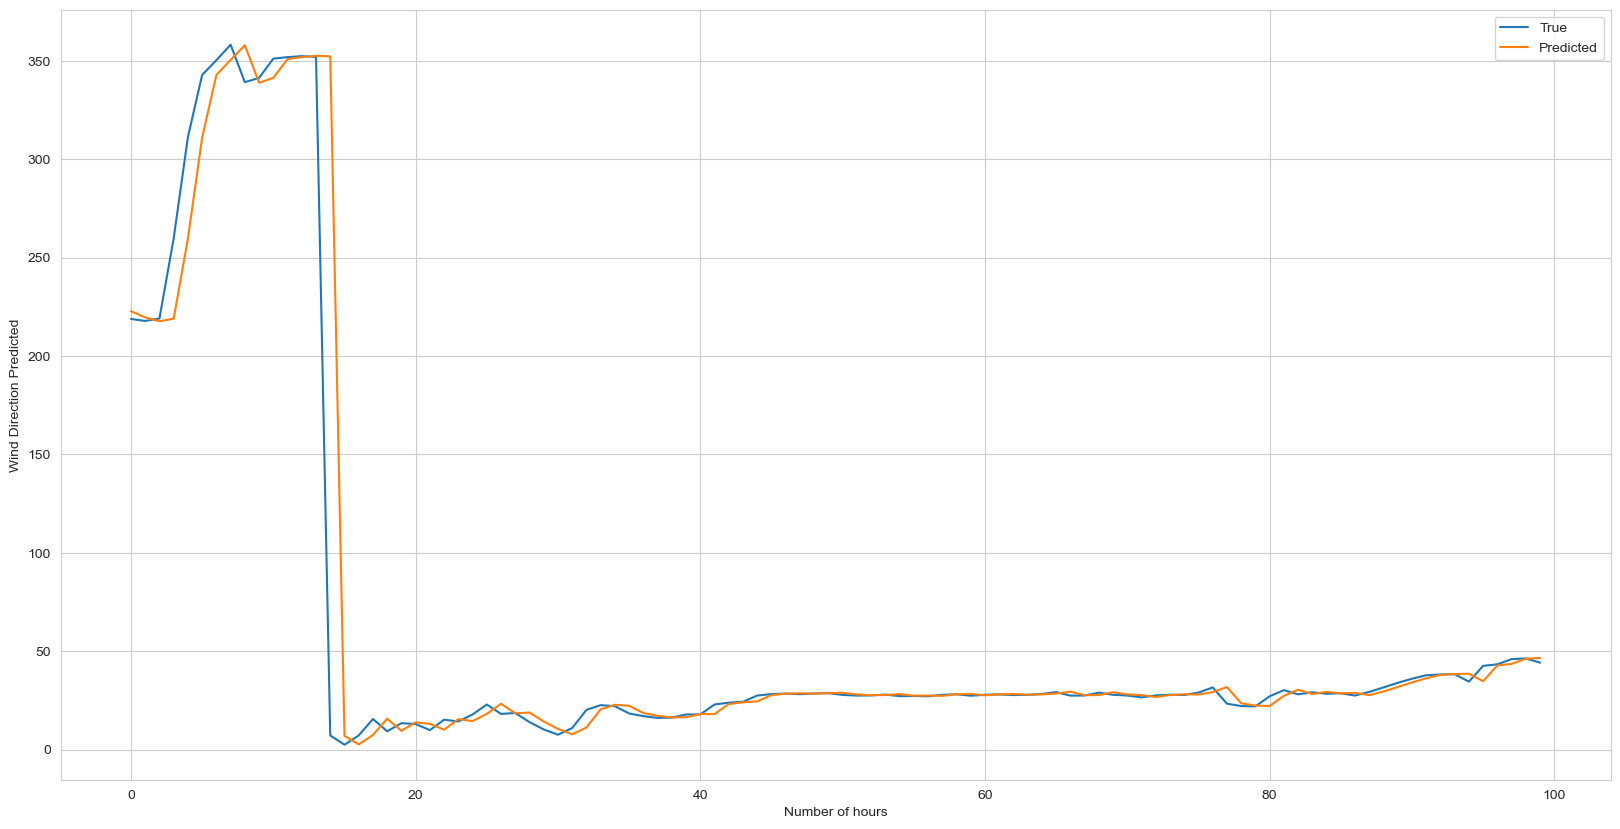

In [33]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
pyplot.figure(figsize=(20,10))
pyplot.plot(expectations_plot[0:100], label="True")
pyplot.plot(predictions_plot[0:100], label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Wind Direction Predicted")
pyplot.show()

In [34]:
import pickle 

In [35]:
Pkl_Filename = "Forcasting_WindDirection(E).pkl" 

In [36]:
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lstm_model, file)

In [37]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model